# 匹配滤波算法及其变体

必要的库和依赖

In [4]:
import numpy as np
import sys
sys.path.append("C:\\Users\\RS\\VSCode\\matchedfiltermethod")

import MyFunctions.AHSI_data as ad
import MyFunctions.EMIT_data as ed
from MyFunctions.needed_function import open_unit_absorption_spectrum

In [9]:
def test(method,ax,*args):
    tif_file_path = r"F:\\AHSI_part1\\GF5B_AHSI_E100.0_N26.4_20231004_011029_L10000400374\\GF5B_AHSI_E100.0_N26.4_20231004_011029_L10000400374_SW.tif"
    bands,radiance = ad.get_calibrated_radiance(tif_file_path,2100,2500)
    # define the path of the unit absorption spectrum file
    ahsi_unit_absorption_spectrum_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_50000.txt"
    bands, uas = open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2100,2500)
    # call the main function to process the radiance file 
    c = method(radiance,uas,*args)
    # 创建网格
    x = np.arange(c.shape[1])  # 列索引
    y = np.arange(c.shape[0])  # 行索引
    X, Y = np.meshgrid(x, y)
    contour = ax.contourf(X, Y, c, 20, cmap='RdGy')


## 常规匹配滤波算法

### 整幅影像计算

AttributeError: 'function' object has no attribute 'get_array'

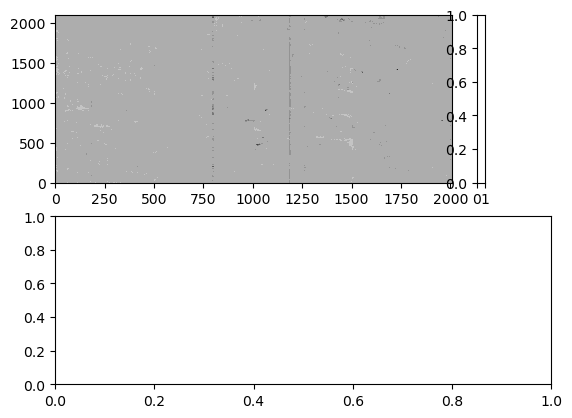

In [13]:
# original matched filter algorithm 整幅图像进行计算
def matched_filter(data_cube: np.array, unit_absorption_spectrum: np.array, albedoadjust, iterate, sparsity):        
    """
    Calculate the methane enhancement of the image data based on the original matched filter
    and the unit absorption spectrum.
    
    :param data_array: numpy array of the image data
    :param unit_absorption_spectrum: list of the unit absorption spectrum
    :param albedoadjust: bool, whether to adjust the albedo
    :param iterate: bool, whether to iterate
    :param sparsity: bool, whether to use l1filter
    :return: numpy array of the methane enhancement
    """
    
    # 获取波段 行数 列数 初始化 concentration 数组，大小与卫星数据尺寸一直
    bands, rows, cols = data_cube.shape
    concentration = np.zeros((rows, cols))
    
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱
    background_spectrum = np.nanmean(data_cube, axis=(1,2))
    target_spectrum = background_spectrum*unit_absorption_spectrum
    radiancediff_with_bg =data_cube - background_spectrum[:, None,None]
    
    # 计算协方差矩阵，并获得其逆矩阵
    d_covariance = radiancediff_with_bg
    covariance = np.zeros((bands, bands))
    for row in range(rows): 
        for col in range(cols):
            covariance += np.outer(d_covariance[:, row, col], d_covariance[:, row, col])
    covariance = covariance/(rows*cols)
    covariance_inverse = np.linalg.pinv(covariance)
    
    # 判断是否进行反照率校正，若是，则通过背景光谱和实际光谱计算反照率校正因子
    albedo = np.ones((rows, cols))
    if albedoadjust:
        for row in range(rows):
            for col in range(cols):
                albedo[row, col] = (
                        (data_cube[:,row,col].T @ background_spectrum) /
                        (background_spectrum.T @ background_spectrum)
                )
    
    # 基于最优化公式计算每个像素的甲烷浓度增强值
    for row in range(rows):
        for col in range(cols):
            numerator = (radiancediff_with_bg[:,row,col].T @ covariance_inverse @ target_spectrum)
            denominator = albedo[row,col]*(target_spectrum.T @ covariance_inverse @ target_spectrum)
            concentration[row,col] = numerator/denominator

    # 判断是否进行迭代，若是，则进行如下迭代计算
    if iterate:
        # 初始化 l1filter 数组
        l1filter = np.zeros((rows,cols))
        for iter_num in range(5):
            print("iteration: No.", iter_num + 1)
            # 判断是否进行 l1filter 校正，若是则给予前一步的浓度值计算 l1filter
            if sparsity:
                for row in range(rows):
                    for col in range(cols):
                        l1filter = 1 / (concentration[row,col] + np.finfo(np.float64).tiny)
            
            # 更新背景光谱和目标光谱,并计算进行观测光谱和背景光谱差值   
            background_spectrum = np.mean(data_cube - (albedo*concentration)[None,:,:]*target_spectrum[:,None,None],
                                          axis=(1,2))
            target_spectrum = np.multiply(background_spectrum, unit_absorption_spectrum)
            radiancediff_with_bg = data_cube - background_spectrum[:,None,None]
            
            # 基于新的目标谱和背景光谱 计算协方差矩阵
            d_covariance = data_cube -(albedo*concentration)[None,:,:]*target_spectrum[:,None,None] - background_spectrum[:,None,None]
            covariance = np.zeros((bands, bands))
            for row in range(rows):
                for col in range(cols):
                    covariance += np.outer(d_covariance[:,row,col], d_covariance[:,row,col])
            covariance = covariance/(rows*cols)
            covariance_inverse = np.linalg.pinv(covariance)

            # 基于最优化估计公式 计算新的甲烷浓度增强值
            for row in range(rows):
                for col in range(cols):
                    numerator = (radiancediff_with_bg[:,row,col].T @ covariance_inverse @ target_spectrum) - l1filter[row,col]
                    denominator = albedo[row,col] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                    concentration[row,col] = np.maximum(numerator / denominator, 0.0)
                    
    return concentration

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
test(matched_filter,ax,False,False,False)
plt.colorbar(ax.contourf)
plt.show()


### column-wise 进行计算

C:\Users\RS\AppData\Local\Temp\ipykernel_10600\647088855.py:93: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ax.contourf)


AttributeError: 'function' object has no attribute 'get_array'

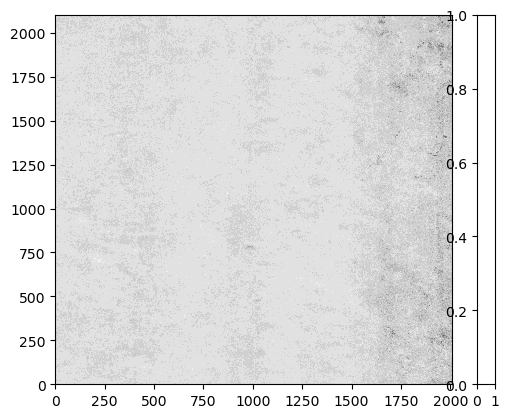

In [14]:
# orginal matched filter algorithm 逐列计算
def columnwise_matched_filter(data_cube: np.array, unit_absorption_spectrum: np.array, iterate=False,
                   albedoadjust=False, sparsity=False):
    """
    Calculate the methane enhancement of the image data based on the original matched filter
    and the unit absorption spectrum.
    
    :param data_array: numpy array of the image data
    :param unit_absorption_spectrum: list of the unit absorption spectrum
    :param albedoadjust: bool, whether to adjust the albedo
    :param iterate: bool, whether to iterate
    :param sparsity: bool, whether to use l1filter
    :return: numpy array of the methane enhancement
    """
    # 获取波段 行数 列数 ,并初始化 concentration 数组
    bands, rows, cols = data_cube.shape
    concentration = np.zeros((rows, cols))
    
    # 遍历不同列数，目的是为了消除 不同传感器之间带来的误差
    for col_index in range(cols):
        # 获取当前列的数据 获取当前列的非空行的 索引 以及 数目
        current_column = data_cube[:, :, col_index]
        valid_rows = ~np.isnan(current_column[0, :])
        count_not_nan = np.count_nonzero(valid_rows)
        
        # 对于全为空的列，直接将浓度值设为 nan
        if count_not_nan == 0:
            concentration[:, col_index] = np.nan
            continue

        # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱,并计算观测光谱和背景光谱的差值
        background_spectrum = np.nanmean(current_column, axis=1)
        target_spectrum = background_spectrum*unit_absorption_spectrum
        radiancediff_with_bg = current_column[:, valid_rows] - background_spectrum[:, None]
        
        # 计算协方差矩阵，并获得其逆矩阵
        d_covariance = radiancediff_with_bg
        covariance = np.zeros((bands, bands))
        for i in range(count_not_nan):
            covariance += np.outer(d_covariance[:, i], d_covariance[:, i])
        covariance = covariance/count_not_nan
        covariance_inverse = np.linalg.pinv(covariance)

        # 判断是否进行反照率校正，若是，则通过背景光谱和实际光谱计算反照率校正因子
        albedo = np.ones((rows, cols))
        if albedoadjust:
            albedo[valid_rows, col_index] = (
                    (current_column[:, valid_rows].T @ background_spectrum) /
                    (background_spectrum.T @ background_spectrum)
            )

        # 基于最优化公式计算每个像素的甲烷浓度增强值
        numerator = (radiancediff_with_bg.T @ covariance_inverse @ target_spectrum)
        denominator = albedo[valid_rows, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
        concentration[valid_rows, col_index] = numerator/denominator
        
        # 判断是否进行迭代，若是，则进行如下迭代计算
        if iterate:
            # 初始化 l1filter 数组
            l1filter = np.zeros((rows, cols))
            epsilon = np.finfo(np.float64).tiny
            # 迭代计算
            for iter_num in range(5):
                print("iteration: No.", iter_num + 1)
                # 判断是否进行 l1filter 校正，若是则给予前一步的浓度值计算 l1filter
                if sparsity:
                    l1filter[valid_rows, col_index] = 1 / (concentration[valid_rows, col_index] + epsilon)
        
                # 更新背景光谱和目标光谱，计算进行观测光谱和背景光谱差值
                background_spectrum = np.nanmean(current_column[:, valid_rows] - (albedo[valid_rows, col_index] *concentration[valid_rows, col_index])[None,:]*target_spectrum[:,None],
                                                 axis=1)
                target_spectrum = np.multiply(background_spectrum, unit_absorption_spectrum)
                radiancediff_with_bg = current_column[:, valid_rows] - background_spectrum
                
                # 基于新的目标谱 和 背景光谱 计算协方差矩阵
                d_covariance = current_column[:, valid_rows] -(albedo[valid_rows, col_index] *concentration[valid_rows, col_index])[None,:]*target_spectrum[:,None] - background_spectrum[:,None]
                covariance = np.zeros((bands, bands))
                for i in range(valid_rows.shape[0]):
                    covariance += np.outer(d_covariance[:, i], d_covariance[:, i])
                covariance = covariance/count_not_nan
                covariance_inverse = np.linalg.pinv(covariance)

                # 计算新的甲烷浓度增强值
                numerator = (radiancediff_with_bg.T @ covariance_inverse @ target_spectrum) - l1filter[valid_rows, col_index]
                denominator = albedo[valid_rows, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                concentration[valid_rows, col_index] = np.maximum(numerator / denominator, 0.0)
                
    # 返回甲烷浓度增强和反照率校正
    return concentration
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
test(columnwise_matched_filter,ax,False,False,False)
plt.show()



## 多层匹配滤波算法

### 整幅图像进行计算

In [ ]:

def ML_matched_filter(data_cube: np.array, unit_absorption_spectrum: np.array,albedoadjust,sparsity) -> np.array:
    """
    Calculate the methane enhancement of the image data based on the modified matched filter
    and the unit absorption spectrum.

    :param data_cube: numpy array of the image data
    :param unit_absorption_spectrum: list of the unit absorption spectrum
    :param albedoadjust: bool, whether to adjust the albedo
    :param sparsity: bool, whether to use l1filter
    :return: numpy array of methane enhancement result
    """
    # 获取 以 波段 行数 列数 为顺序的数据,初始化 concentration 数组，大小与卫星数据尺寸一致
    bands, rows, cols = data_cube.shape
    concentration = np.zeros((rows, cols))
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱,并计算背景光谱与目标光谱的差值用于后续浓度计算
    background_spectrum = np.nanmean(data_cube, axis=(1,2))
    target_spectrum = background_spectrum*unit_absorption_spectrum[0]
    radiancediff_with_bg = data_cube - background_spectrum[:, None,None]

    # 计算协方差矩阵，并获得其逆矩阵
    d_covariance = radiancediff_with_bg
    covariance = np.zeros((bands, bands))
    for row in range(rows): 
        for col in range(cols):
            covariance += np.outer(d_covariance[:, row, col], d_covariance[:, row, col])
    covariance = covariance/(rows*cols)
    covariance_inverse = np.linalg.pinv(covariance)
   
    if albedoadjust:
        albedo = np.ones((rows, cols))
        for row in range(rows):
            for col in range(cols):
                albedo[row, col] = (
                        (data_cube[:,row,col].T @ background_spectrum) /
                        (background_spectrum.T @ background_spectrum)
                )
   
    # 逐像素计算甲烷浓度增强值
    for row in range(rows):
        for col in range(cols):
            # 基于最优化公式计算每个像素的甲烷浓度增强值
            numerator = (radiancediff_with_bg[:,row,col].T @ covariance_inverse @ target_spectrum)
            denominator = albedo[row,col]*(target_spectrum.T @ covariance_inverse @ target_spectrum)
            concentration[row,col] = numerator/denominator

    # 备份原始浓度值
    original_concentration = concentration.copy()
    
    # 多层单位吸收光谱计算
    levelon = True
    adaptive_threshold = 6000
    i = 1
    high_concentration_mask = original_concentration > adaptive_threshold*(0.99**i)
    low_concentration_mask = original_concentration <= adaptive_threshold*(0.99**i)

    while levelon:
        if np.sum(high_concentration_mask) > 0:
            print("current threshold:",adaptive_threshold)
            
            background_spectrum = np.nanmean(data_cube - concentration * target_spectrum[:, None, None], axis=(1, 2))
            target_spectrum = background_spectrum * unit_absorption_spectrum[0]
            
            new_background_spectrum = background_spectrum
            for n in range(i):
                new_background_spectrum += 6000*new_background_spectrum*unit_absorption_spectrum[n]
            high_target_spectrum = new_background_spectrum * unit_absorption_spectrum[i]
            
            radiancediff_with_bg[:,high_concentration_mask] = (
                data_cube[:,high_concentration_mask] - new_background_spectrum[:,None]
            )
            radiancediff_with_bg[:,low_concentration_mask] = (
                data_cube[:,low_concentration_mask] - background_spectrum[:,None]
            )
            
            # d_covariance[:,high_concentration_mask] = data_cube[:,high_concentration_mask] - (
            #     (concentration[high_concentration_mask]-adaptive_threshold)*high_target_spectrum[:,None] + new_background_spectrum[:,None]
            # )
            d_covariance[:,high_concentration_mask] = data_cube[:,high_concentration_mask] - (
                background_spectrum[:,None] + concentration[high_concentration_mask]*target_spectrum[:,None]
            )
            
            d_covariance[:,low_concentration_mask] = data_cube[:,low_concentration_mask] - (
                background_spectrum[:,None] + concentration[low_concentration_mask]*target_spectrum[:,None]
            )
            covariance = np.zeros((bands, bands))
            for row in range(rows):
                for col in range(cols):
                    covariance += np.outer(d_covariance[:, row, col], d_covariance[:, row, col])
            covariance /= rows*cols
            covariance_inverse = np.linalg.inv(covariance) 
            
            # concentration[high_concentration_mask] = (
            #     (radiancediff_with_bg[:, high_concentration_mask].T @ covariance_inverse @high_target_spectrum) / 
            #     (high_target_spectrum.T @ covariance_inverse @ high_target_spectrum)
            # ) + adaptive_threshold
            
            concentration[high_concentration_mask] = (
                (radiancediff_with_bg[:, high_concentration_mask].T @ high_target_spectrum) / 
                (high_target_spectrum.T @  high_target_spectrum)
            ) + adaptive_threshold
            
            
            high_concentration_mask = original_concentration > adaptive_threshold*0.99
            low_concentration_mask = original_concentration <= adaptive_threshold*0.99
            
            if adaptive_threshold < 32000:
                adaptive_threshold += 6000
                i += 1
            else: 
                levelon = False

        else:
            levelon = False

    return concentration, original_concentration



### column-wise 进行计算

In [ ]:

# modified matched filter algorithm 逐列计算
def columnwise_ML_matched_filter(data_array: np.array, stacked_unit_absorption_spectrum: np.array, is_iterate=False,
                   is_albedo=False, is_filter=False, is_columnwise=False) -> np.array:
    """
    Calculate the methane enhancement of the image data based on the original matched filter
    and the unit absorption spectrum.

    :param data_array: numpy array of the image data
    :param unit_absorption_spectrum: list of the unit absorption spectrum
    :param is_iterate: flag to decide whether to iterate the matched filter
    :param is_albedo: flag to decide whether to do the albedo correction
    :param is_filter: flag to decide whether to add the l1-filter correction
    :return: numpy array of methane enhancement result
    """
    # 获取 以 波段 行数 列数 为顺序的数据
    bands, rows, cols = data_array.shape
    # 初始化 concentration 数组，大小与卫星数据尺寸一直
    concentration = np.zeros((rows, cols))
    # 遍历不同列数，目的是为了消除 不同传感器之间带来的误差
    if is_columnwise:
        for col_index in range(cols):
            # 获取当前列的数据
            current_column = data_array[:, :, col_index]
            # 获取当前列的非空行的 索引 以及 数目
            valid_rows = ~np.isnan(current_column[0, :])
            count_not_nan = np.count_nonzero(valid_rows)
            # 对于全为空的列，直接将浓度值设为 nan
            if count_not_nan == 0:
                concentration[:, col_index] = np.nan
                continue

            # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱
            background_spectrum = np.nanmean(current_column, axis=1)
            target_spectrum = background_spectrum*stacked_unit_absorption_spectrum[0,:]

            # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
            radiancediff_with_bg = current_column[:, valid_rows] - background_spectrum[:, None]
            covariance = np.zeros((bands, bands))
            for i in range(count_not_nan):
                covariance += np.outer(radiancediff_with_bg[:, i], radiancediff_with_bg[:, i])
            covariance = covariance/count_not_nan
            covariance_inverse = np.linalg.inv(covariance)

            # 判断是否进行反照率校正，若是，则通过背景光谱和实际光谱计算反照率校正因子
            albedo = np.ones((rows, cols))
            if is_albedo:
                albedo[valid_rows, col_index] = (
                        (current_column[:, valid_rows].T @ background_spectrum) /
                        (background_spectrum.T @ background_spectrum)
                )

            # 基于最优化公式计算每个像素的甲烷浓度增强值
            up = (radiancediff_with_bg.T @ covariance_inverse @ target_spectrum)
            down = albedo[valid_rows, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
            concentration[valid_rows, col_index] = up / down
            
            levelon = True
            # 计算浓度增强值的均值和标准差
            mean_concentration = np.nanmean(concentration[valid_rows, col_index])  # 忽略 NaN 值
            std_concentration = np.nanstd(concentration[valid_rows, col_index])    # 忽略 NaN 值
            # 使用均值加一个标准差作为自适应阈值
            adaptive_threshold = mean_concentration + std_concentration
            while levelon:
                high_concentration_mask = concentration[valid_rows, col_index] > adaptive_threshold
                # 获取这个阈值的单位吸收谱，可以通过插值查找表获得
                # 使用新的单位吸收谱重新计算目标光谱
                background_spectrum = np.nanmean(current_column[:,valid_rows] + albedo[valid_rows,col_index]*concentration[valid_rows,col_index]*target_spectrum[:, np.newaxis], axis=1)
                background_spectrum = background_spectrum + adaptive_threshold*stacked_unit_absorption_spectrum[1,:]
                target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum[1,:])
                radiancediff_with_bg = current_column[:, valid_rows] - background_spectrum[:, None] - albedo[valid_rows,col_index]*(concentration[valid_rows,col_index]-adaptive_threshold)*target_spectrum[:, np.newaxis] 
                covariance = np.zeros((bands, bands))
                for i in range(valid_rows.shape[0]):
                    covariance += np.outer(radiancediff_with_bg[:, i], radiancediff_with_bg[:, i])
                covariance = covariance/count_not_nan
                covariance_inverse = np.linalg.inv(covariance)
                # 基于新的目标光谱重新计算高浓度像素的甲烷浓度增强值
                up = (radiancediff_with_bg[:, high_concentration_mask].T @ covariance_inverse @ target_spectrum)
                down = albedo[valid_rows, col_index][high_concentration_mask] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                # 直接更新原数组
                valid_indices = np.where(valid_rows)[0]
                high_concentration_indices = valid_indices[high_concentration_mask]
                concentration[high_concentration_indices, col_index] = up / down + adaptive_threshold
                # 计算浓度增强值的均值和标准差
                mean_concentration = np.nanmean(concentration[valid_rows, col_index])  # 忽略 NaN 值
                std_concentration = np.nanstd(concentration[valid_rows, col_index])    # 忽略 NaN 值
                # 使用均值加一个标准差作为自适应阈值
                new_adaptive_threshold = mean_concentration + std_concentration
                if np.abs((new_adaptive_threshold-adaptive_threshold)/adaptive_threshold) < 0.1:
                    adaptive_threshold = new_adaptive_threshold
                else:
                    levelon = False

            # 判断是否进行迭代，若是，则进行如下迭代计算
            if is_iterate:
                l1filter = np.zeros((rows, cols))
                epsilon = np.finfo(np.float32).tiny
                for iter_num in range(5):
                    if is_filter:
                        l1filter[valid_rows, col_index] = 1 / (concentration[valid_rows, col_index] + epsilon)
                    else:
                        l1filter[valid_rows, col_index] = 0
                    
                    # 更新背景光谱和目标光谱
                    column_replacement = current_column[:, valid_rows] - (albedo[valid_rows, col_index] *concentration[valid_rows, col_index])[None,:]*target_spectrum[:,None]
                    # 计算更新后的 背景光谱 和 目标谱
                    background_spectrum = np.mean(column_replacement, axis=1)
                    target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum[0,:])
                    # 基于新的目标谱 和 背景光谱 计算协方差矩阵
                    radiancediff_with_bg = current_column[:, valid_rows] -(albedo[valid_rows, col_index] *concentration[valid_rows, col_index])[None,:]*target_spectrum[:,None] - background_spectrum[:,None]
                    covariance = np.zeros((bands, bands))
                    for i in range(valid_rows.shape[0]):
                        covariance += np.outer(radiancediff_with_bg[:, i], radiancediff_with_bg[:, i])
                    covariance = covariance/count_not_nan
                    covariance_inverse = np.linalg.inv(covariance)

                    # 计算新的甲烷浓度增强值
                    up = (radiancediff_with_bg.T @ covariance_inverse @ target_spectrum) - l1filter[valid_rows, col_index]
                    down = albedo[valid_rows, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                    concentration[valid_rows, col_index] = np.maximum(up / down, 0.0)
                    high_concentration_mask = concentration[valid_rows, col_index] > 5000
                    
                    if np.any(high_concentration_mask):
                        # 使用新的单位吸收谱重新计算目标光谱
                        con = concentration[valid_rows, col_index].copy()
                        background_spectrum = np.nanmean(current_column[:,valid_rows] - albedo[valid_rows,col_index]*con*target_spectrum[:, np.newaxis], axis=1)
                        target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum)
                        radiancediff_with_bg = current_column[:, valid_rows] -albedo[valid_rows,col_index]*con*target_spectrum[:, np.newaxis] - background_spectrum[:, None]
                        covariance = np.zeros((bands, bands))
                        for i in range(valid_rows.shape[0]):
                            covariance += np.outer(radiancediff_with_bg[:, i], radiancediff_with_bg[:, i])
                        covariance = covariance/count_not_nan
                        covariance_inverse = np.linalg.inv(covariance)
                        # 基于新的目标光谱重新计算高浓度像素的甲烷浓度增强值
                        up = (radiancediff_with_bg[:, high_concentration_mask].T @ covariance_inverse @ target_spectrum)
                        down = albedo[valid_rows, col_index][high_concentration_mask] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                        # 直接更新原数组
                        valid_indices = np.where(valid_rows)[0]
                        high_concentration_indices = valid_indices[high_concentration_mask]
                        concentration[high_concentration_indices, col_index] = up / down + 2500

    if not is_columnwise:
        count_not_nan = np.count_nonzero(~np.isnan(data_array[0, :, :]))
        background_spectrum = np.nanmean(data_array, axis=(1,2))
        target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum[0,:])   
        radiancediff_with_bg = data_array - background_spectrum[:, None, None]
        covariance = np.zeros((bands, bands))
        for i in range(rows):
            for j in range(cols):
                covariance = covariance + np.outer(radiancediff_with_bg[:, i, j], radiancediff_with_bg[:, i, j])
        covariance = covariance / count_not_nan
        covariance_inverse = np.linalg.inv(covariance)
        albedo = np.ones((rows, cols))
        for row_index in range(rows):
            for col_index in range(cols):
                if is_albedo:
                    albedo[row_index, col_index] = (
                        (data_array[:, row_index, col_index].T @ background_spectrum) /
                        (background_spectrum.T @ background_spectrum)
                    )
                up = (radiancediff_with_bg[:,row_index,col_index].T @ covariance_inverse @ target_spectrum)
                down = albedo[row_index, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                concentration[row_index, col_index] = up / down
        
        if is_iterate:
            l1filter = np.zeros((rows, cols))
            epsilon = np.finfo(np.float32).tiny
            iter_data = data_array.copy()
            
            for iter_num in range(5):
                if is_filter:
                    l1filter = 1 / (concentration + epsilon)
                iter_data = data_array - (
                    target_spectrum[:, None, None] * albedo[None, :, :] * concentration[None, :, :]
                )
                background_spectrum = np.nanmean(iter_data, axis=(1,2))
                target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum[0,:])
                radiancediff_with_bg = data_array - background_spectrum[:, None, None]
                covariance = np.zeros((bands, bands))
                for i in range(rows):
                    for j in range(cols):
                        covariance += np.outer(radiancediff_with_bg[:, i, j], radiancediff_with_bg[:, i, j])
                covariance = covariance / count_not_nan
                covariance_inverse = np.linalg.inv(covariance)
                
                for row_index in range(rows):
                    for col_index in range(cols):
                        up = (radiancediff_with_bg[:, row_index, col_index].T @ covariance_inverse @ target_spectrum)
                        down = albedo[row_index, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                        concentration[row_index, col_index] = np.maximum(up / down, 0)

    # 返回 甲烷浓度增强的结果
    return concentration



## lognornal 匹配滤波算法

### 整幅影像进行计算

In [ ]:
# convert the radiance into log space 整幅图像进行计算
def lognormal_matched_filter(data_cube: np.array, unit_absorption_spectrum: np.array):
    # 获取 以 波段 行数 列数 为顺序的数据
    bands, rows, cols = data_cube.shape
    # 初始化 concentration 数组，大小与卫星数据尺寸一直
    concentration = np.zeros((rows, cols))
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱
    log_background_spectrum = np.nanmean(np.log(data_cube), axis=(1,2))
    background_spectrum = np.exp(log_background_spectrum)
    
    # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
    radiancediff_with_bg = np.log(data_cube) - log_background_spectrum[:, None,None]
    d_covariance = np.log(data_cube)-background_spectrum[:,None,None]
    covariance = np.zeros((bands, bands))
    for row in range(rows): 
        for col in range(cols):
            covariance += np.outer(d_covariance[:, row, col], d_covariance[:, row, col])
    covariance = covariance/(rows*cols)
    covariance_inverse = np.linalg.inv(covariance)

    for row in range(rows):
        for col in range(cols):
            # 基于最优化公式计算每个像素的甲烷浓度增强值
            numerator = (radiancediff_with_bg[:,row,col].T @ covariance_inverse @ unit_absorption_spectrum)
            denominator = (unit_absorption_spectrum.T @ covariance_inverse @ unit_absorption_spectrum)
            concentration[row,col] = numerator/denominator
    return concentration


### column-wise 进行计算

In [ ]:

# convert the radiance into log space 逐列计算
def columnwise_lognormal_matched_filter(data_cube: np.array, unit_absorption_spectrum: np.array):
    # 获取 以 波段 行数 列数 为顺序的数据
    bands, rows, cols = data_cube.shape
    # 初始化 concentration 数组，大小与卫星数据尺寸一直
    concentration = np.zeros((rows, cols))
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱
    background_spectrum = np.nanmean(data_cube, axis=(1,2))
    target_spectrum = background_spectrum*unit_absorption_spectrum

    # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
    radiancediff_with_bg = data_cube - background_spectrum[:, None,None]
    covariance = np.zeros((bands, bands))
    for row in range(rows): 
        for col in range(cols):
            covariance += np.outer(radiancediff_with_bg[:, row, col], radiancediff_with_bg[:, row, col])
    covariance = covariance/(rows*cols)
    covariance_inverse = np.linalg.inv(covariance)

    for row in range(rows):
        for col in range(cols):
            # 基于最优化公式计算每个像素的甲烷浓度增强值
            numerator = (radiancediff_with_bg[:,row,col].T @ covariance_inverse @ target_spectrum)
            denominator = (target_spectrum.T @ covariance_inverse @ target_spectrum)
            concentration[row,col] = numerator/denominator
    return concentration



##  Kalman filter 匹配滤波算法

### 整幅影像进行计算

In [ ]:
def Kalman_filterr_matched_filter(data_cube: np.array, unit_absorption_spectrum: np.array, albedoadjust, iterate, sparsity):
    
    return None